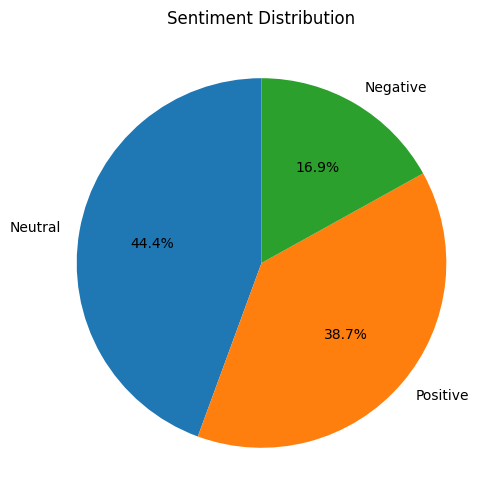

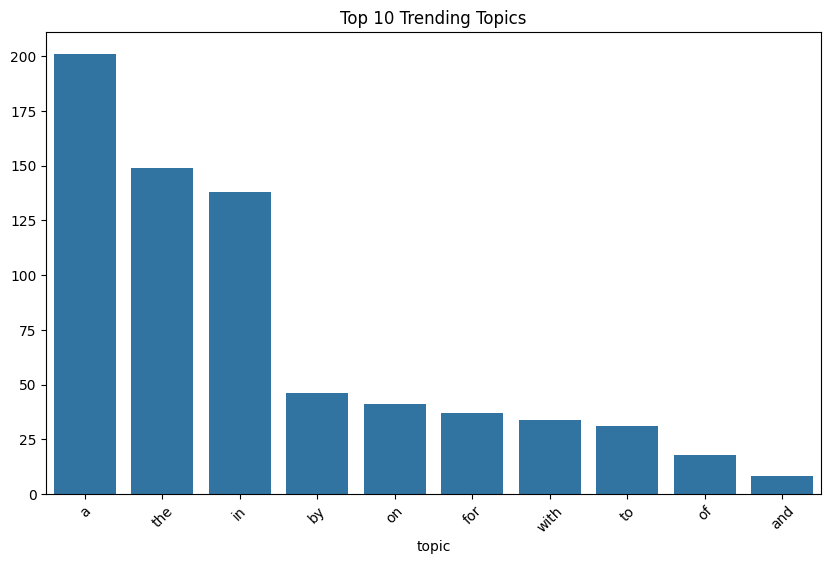

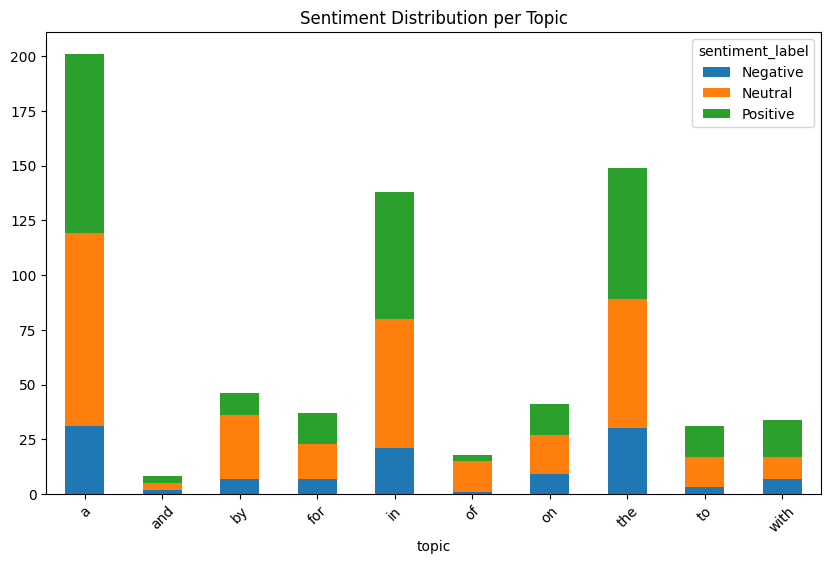

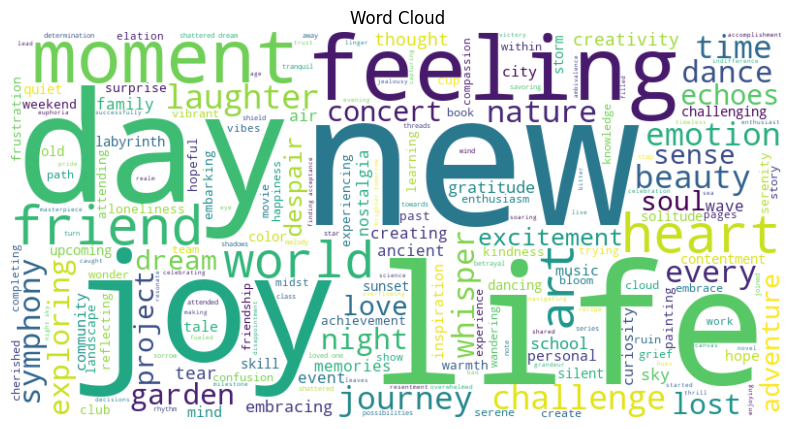

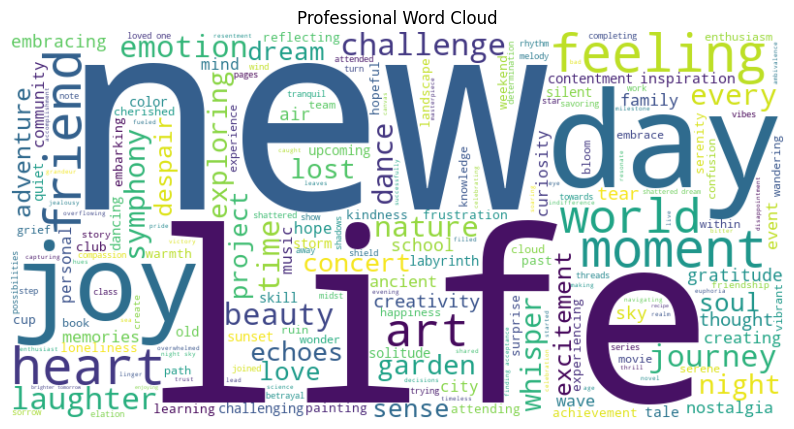

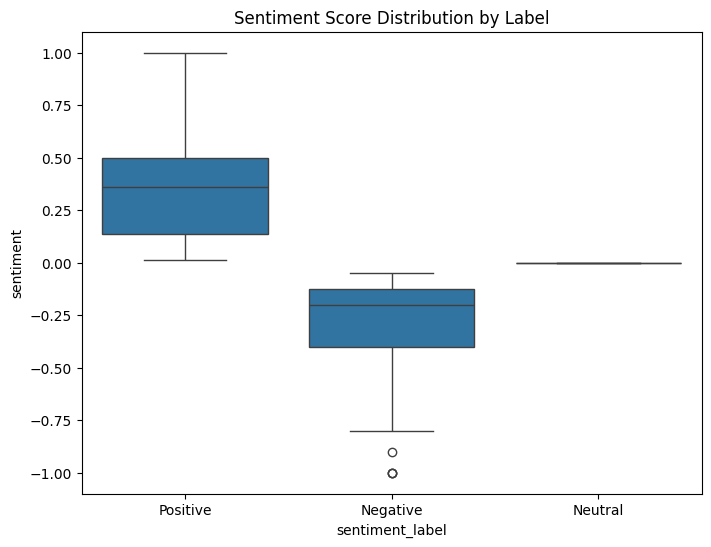

Skipping time-based visualization: 'Date'


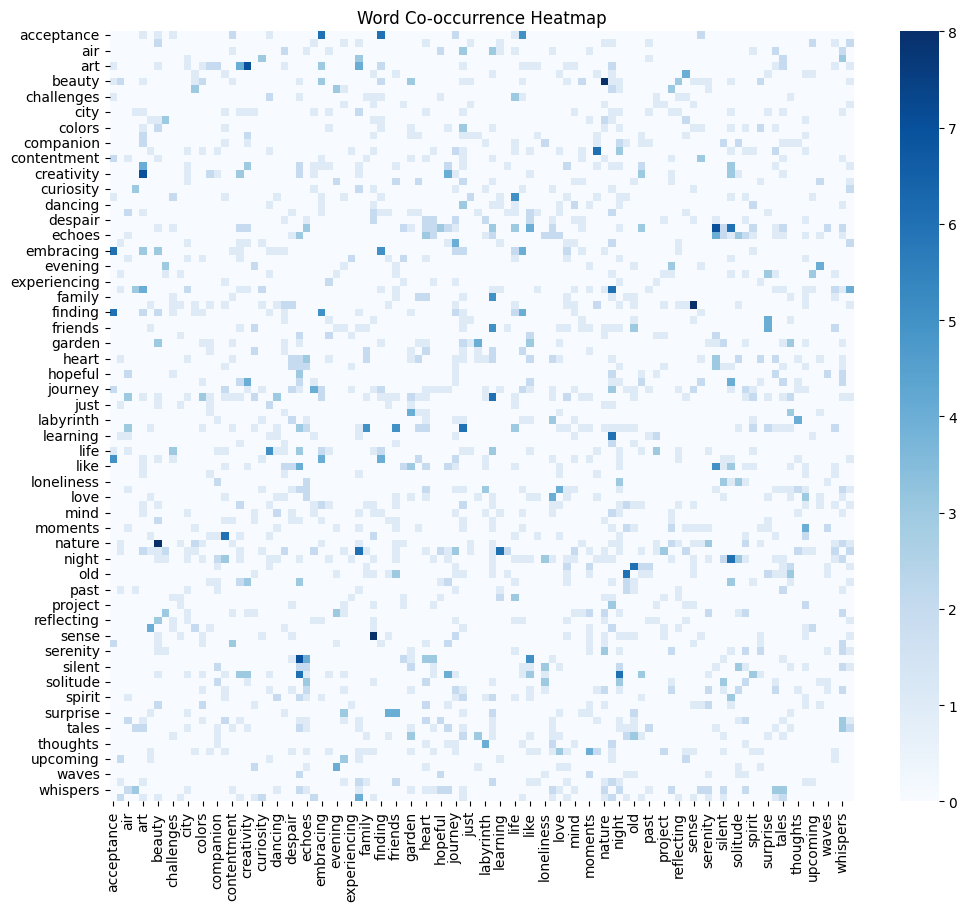

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from plotly import graph_objects as go
from plotly.express import sunburst
from sklearn.feature_extraction.text import CountVectorizer

# Load and clean data
df = pd.read_csv(r"C:\Users\avina\Downloads\archive (10)\sentimentdataset.csv")
df = df.dropna(subset=['Text'])

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+", '', text)
    text = re.sub(r"#\w+", '', text)
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)
    text = text.lower()
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)

# Sentiment analysis
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

def sentiment_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment'].apply(sentiment_label)

# Topic extraction
top_topics = df['cleaned_text'].str.split().explode().value_counts().head(10).index.tolist()
df['topic'] = df['cleaned_text'].apply(lambda x: next((word for word in x.split() if word in top_topics), None))

# Save processed file
df.to_csv(r"processed_sentiment_data_for_dashboard.csv", index=False)

# --- Visualizations ---

# 1. Sentiment distribution pie chart
sentiment_dist = df['sentiment_label'].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
sentiment_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=ax)
ax.set_title('Sentiment Distribution')
plt.ylabel('')
plt.show()

# 2. Top 10 trending topics bar chart
topic_dist = df['topic'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=topic_dist.index, y=topic_dist.values, ax=ax)
ax.set_title('Top 10 Trending Topics')
plt.xticks(rotation=45)
plt.show()

# 3. Sentiment distribution per topic (stacked bar)
topic_sentiment = df.groupby('topic')['sentiment_label'].value_counts().unstack().fillna(0)
topic_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution per Topic')
plt.xticks(rotation=45)
plt.show()

# 4. Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# 5. Sunburst chart
sunburst_data = df.groupby(['sentiment_label', 'topic']).size().reset_index(name='counts')
fig = sunburst(sunburst_data, path=['sentiment_label', 'topic'], values='counts')
fig.update_layout(title="Sentiment Distribution by Topic")
fig.show()

# 6. Bar chart of topics
topic_count = df['topic'].value_counts().reset_index()
topic_count.columns = ['Topic', 'Count']
fig = go.Figure(data=[go.Bar(x=topic_count['Topic'], y=topic_count['Count'])])
fig.update_layout(title="Trending Topics", xaxis_title="Topic", yaxis_title="Count")
fig.show()

# 7. Professional word cloud with Viridis colormap
wordcloud_professional = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(df['cleaned_text']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_professional, interpolation='bilinear')
plt.axis('off')
plt.title('Professional Word Cloud')
plt.show()

# --- New Visualizations ---

# 8. Boxplot of sentiment scores
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment_label', y='sentiment', data=df)
plt.title('Sentiment Score Distribution by Label')
plt.show()

# 9. Radar chart for sentiment per topic
topics = topic_sentiment.index.tolist()
categories = topic_sentiment.columns.tolist()

fig = go.Figure()
for category in categories:
    fig.add_trace(go.Scatterpolar(
        r=topic_sentiment[category],
        theta=topics,
        fill='toself',
        name=category
    ))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="Radar Chart: Sentiment Distribution Across Topics",
    showlegend=True
)
fig.show()

# 10. Donut chart for sentiment
fig = go.Figure(data=[go.Pie(labels=sentiment_dist.index,
                             values=sentiment_dist.values,
                             hole=.4)])
fig.update_layout(title='Sentiment Distribution (Donut Chart)')
fig.show()

# 11. Treemap of sentiment by topic
fig = go.Figure(go.Treemap(
    labels=sunburst_data['topic'],
    parents=sunburst_data['sentiment_label'],
    values=sunburst_data['counts']
))
fig.update_layout(title='Treemap of Sentiment by Topic')
fig.show()

# 12. Sentiment over time (requires 'Date' column)
try:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)

    time_sentiment = df.groupby(df['Date'].dt.to_period("M"))['sentiment'].mean().reset_index()
    time_sentiment['Date'] = time_sentiment['Date'].astype(str)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Date', y='sentiment', data=time_sentiment)
    plt.title('Average Sentiment Over Time')
    plt.xticks(rotation=45)
    plt.show()
except Exception as e:
    print("Skipping time-based visualization:", e)

# 13. Word co-occurrence heatmap
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
Xc = (X.T @ X)
Xc.setdiag(0)

df_cooc = pd.DataFrame(Xc.toarray(), index=vectorizer.get_feature_names_out(), columns=vectorizer.get_feature_names_out())

plt.figure(figsize=(12, 10))
sns.heatmap(df_cooc, cmap='Blues')
plt.title('Word Co-occurrence Heatmap')
plt.show()
